In [1]:
import os
import pickle
import re
import shutil
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

In [2]:
def summarize_metric_sweep_lr(base_dir, algorithms, datasets, lr_values, metric="test_accuracy"):
    """
    Computes mean and std of a specified metric (e.g., test_accuracy or test_loss) over seeds,
    for each learning rate in `lr_values`. Displays results by algorithm (rows) and dataset (columns),
    grouped by learning rate with the LR value shown only once per block.

    Returns:
        summary_stats: dict[lr][algorithm][dataset] = (mean, std)
    """

    # folder_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2})_(\d+)_([\d]+)")
    folder_pattern = re.compile(r"(\d+)_([\d]+)_EpochSeed")

    # Store results: {lr -> algorithm -> dataset -> values}
    summary_stats = defaultdict(lambda: defaultdict(dict))
    all_rows = []

    for lr_value in lr_values:
        results = defaultdict(lambda: defaultdict(list))

        for entry in os.listdir(base_dir):
            if not folder_pattern.match(entry):
                continue
            run_dir = os.path.join(base_dir, entry)

            for dataset in datasets:
                dataset_path = os.path.join(run_dir, dataset)
                lr_folder = os.path.join(dataset_path, f"lr{lr_value}")
                if not os.path.isdir(lr_folder):
                    continue

                for algorithm in algorithms:
                    result_file = os.path.join(lr_folder, f"{algorithm}.pkl")
                    if os.path.isfile(result_file):
                        with open(result_file, 'rb') as f:
                            data = pickle.load(f)
                            val = data.get(metric)
                            if val is not None:
                                results[algorithm][dataset].append(val)

        # Compute mean/std for this learning rate
        for algorithm in algorithms:
            row = [lr_value if algorithm == algorithms[0] else "", algorithm]
            for dataset in datasets:
                vals = results[algorithm][dataset]
                if vals:
                    mean_val = np.mean(vals)
                    std_val = np.std(vals)
                    summary_stats[lr_value][algorithm][dataset] = (mean_val, std_val)
                    row.append(f"{mean_val:.4f} ± {std_val:.4f}")
                else:
                    summary_stats[lr_value][algorithm][dataset] = None
                    row.append("-")
            all_rows.append(row)

    # Build headers
    headers = ["LR", "Algorithm"] + datasets
    table_str = tabulate(all_rows, headers=headers, tablefmt="fancy_grid")
    print(table_str)
    return summary_stats

In [3]:
def plot_algorithm_performance(summary_stats, algorithms, datasets, lr_values, metric_name="Test Accuracy"):
    """
    Plot bar charts with error bars showing mean and std for each algorithm at different learning rates,
    one plot per dataset, with improved spacing, consistent y-axis, a horizontal line for best performance,
    and transparency on non-best bars. Each algorithm is assigned a consistent color.
    """
    def get_algorithm_colors(algorithms):  # TODO: Take out. Define only in one place
        """
        Returns a dictionary mapping each algorithm to a distinct color from the 'tab10' colormap.
        """
        num_colors = len(algorithms)
        colormap = plt.get_cmap('tab10', num_colors)
        color_map = {algorithm: colormap(i) for i, algorithm in enumerate(algorithms)}
        return color_map

    num_lrs = len(lr_values)
    num_algos = len(algorithms)
    bar_width = 0.15
    group_spacing = 0.4  # space between groups
    total_group_width = num_algos * bar_width + group_spacing
    x = np.arange(num_lrs) * total_group_width

    color_map = get_algorithm_colors(algorithms)

    for dataset in datasets:
        plt.figure(figsize=(12, 6))

        all_means = []  # store all means to compute the best one

        # First, gather all means to find the best one
        for algorithm in algorithms:
            for lr in lr_values:
                stats = summary_stats.get(lr, {}).get(algorithm, {}).get(dataset)
                if stats is not None:
                    mean, _ = stats
                    all_means.append((mean, algorithm, lr))

        if not all_means:
            continue  # skip empty plots

        # Find the best performing (mean) algorithm-lr pair
        best_mean, best_algo, best_lr = max(all_means, key=lambda x: x[0])

        for i, algorithm in enumerate(algorithms):
            means = []
            stds = []
            alphas = []

            for lr in lr_values:
                stats = summary_stats.get(lr, {}).get(algorithm, {}).get(dataset)
                if stats is not None:
                    mean, std = stats
                else:
                    mean, std = 0, 0
                means.append(mean)
                stds.append(std)

                # Make best bar opaque, others semi-transparent
                if algorithm == best_algo and lr == best_lr:
                    alphas.append(1.0)
                else:
                    alphas.append(0.5)

            x_pos = x + i * bar_width
            bars = plt.bar(x_pos, means, width=bar_width, label=algorithm, yerr=stds,
                           capsize=5, color=color_map[algorithm])

            # Adjust alpha bar by bar
            for bar, a in zip(bars, alphas):
                bar.set_alpha(a)

        # Add horizontal line at best performance
        plt.axhline(y=best_mean, color='gray', linestyle='--', linewidth=1)
        plt.text(x[0] - bar_width * 3.9, best_mean, f"{best_mean:.2f}", va='center', ha='right', color='gray')

        # Plot styling
        plt.xticks(x + (num_algos / 2 - 0.5) * bar_width, lr_values)
        plt.xlabel("Learning Rate")
        plt.ylabel(metric_name)
        plt.title(f"{metric_name} on {dataset}")
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

In [4]:
summary = summarize_metric_sweep_lr(
    base_dir="TM_Experiments/selected_results/",
    algorithms=["SGD", "SGD_CLARA", "SGD_CLARA_us", "Adam", "Adam_CLARA", "Adam_CLARA_us", "D-Adaptation"],
    datasets=["breast_cancer", "iris", "wine", "digits", "mnist", "fmnist", "cifar10", "cifar100"],
    lr_values=["1e-06", "1e-05", "1e-04", "1e-03", "1e-02", "1e-01", "1.00"],  # must match folder name exactly
    metric="test_accuracy"  # test_accuracy or test_loss
)


╒═══════╤═══════════════╤═══════════════════╤═══════════════════╤═══════════════════╤══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤══════════════════╕
│ LR    │ Algorithm     │ breast_cancer     │ iris              │ wine              │ digits           │ mnist             │ fmnist            │ cifar10           │ cifar100         │
╞═══════╪═══════════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╡
│ 1e-06 │ SGD           │ 35.0877 ± 28.1414 │ 28.0000 ± 17.5879 │ 25.0000 ± 16.0054 │ 9.8333 ± 3.2327  │ 11.6580 ± 2.1618  │ 13.1020 ± 6.1303  │ 10.0820 ± 0.1534  │ 0.9780 ± 0.1994  │
├───────┼───────────────┼───────────────────┼───────────────────┼───────────────────┼──────────────────┼───────────────────┼───────────────────┼───────────────────┼──────────────────┤
│       │ SGD_CLARA     │ 92.4561 ± 0.8946  │ 71.3333 ± 10.0222 │ 53.8889 ± 16.2

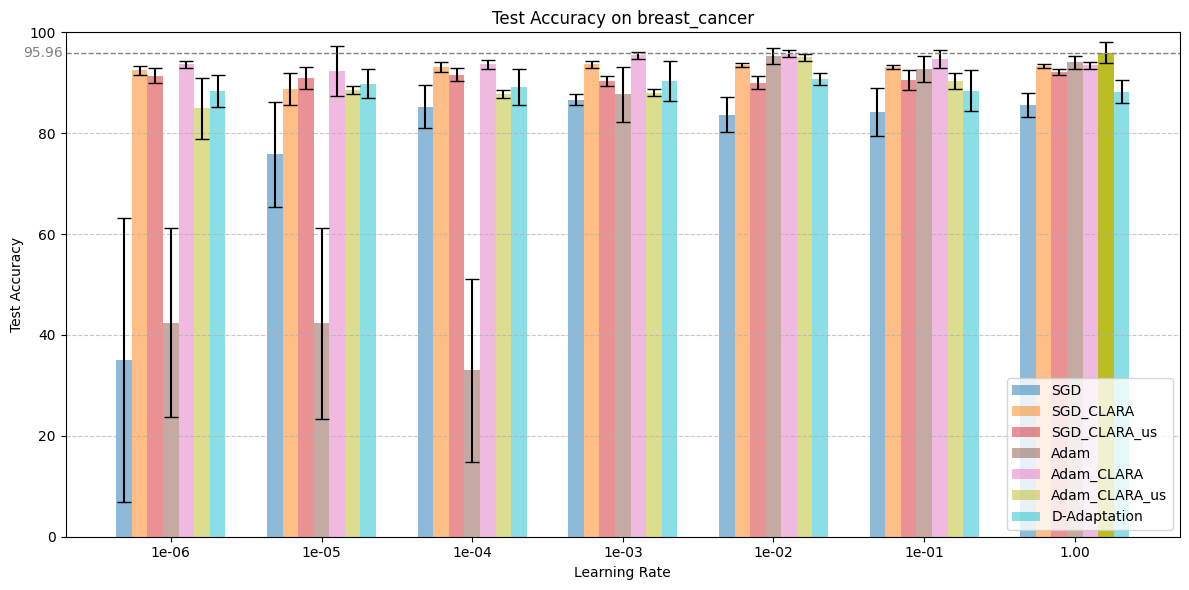

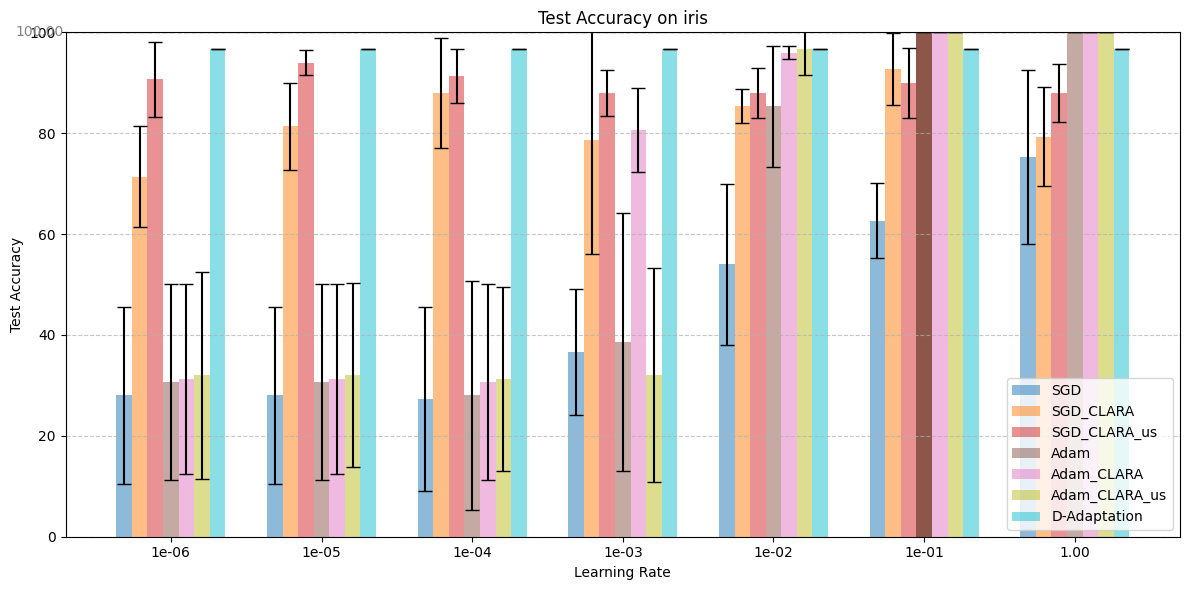

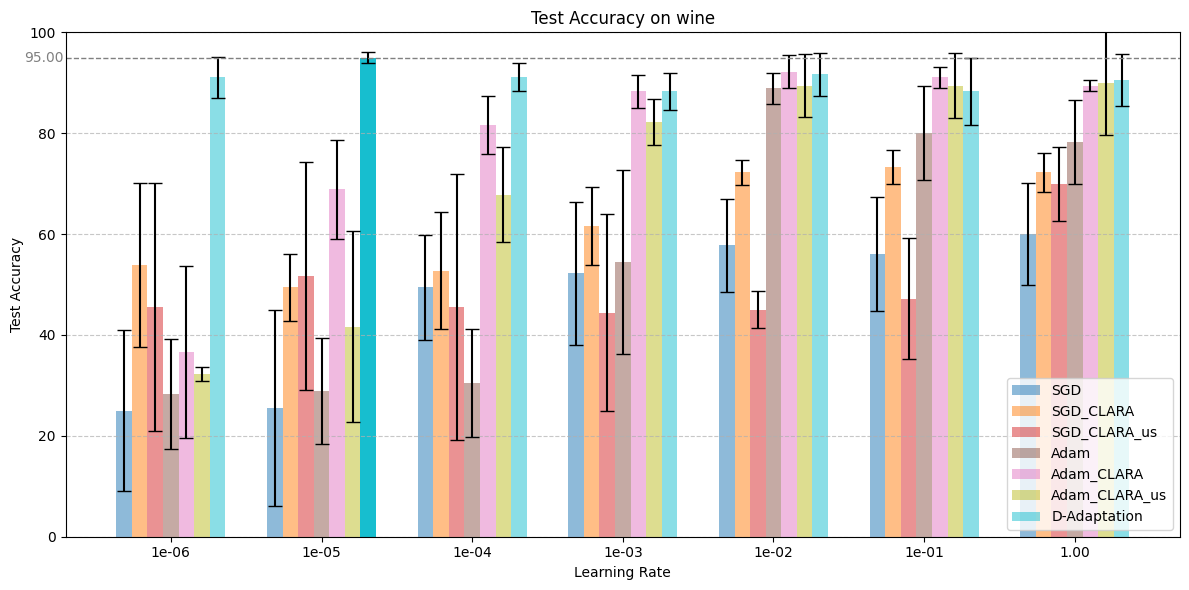

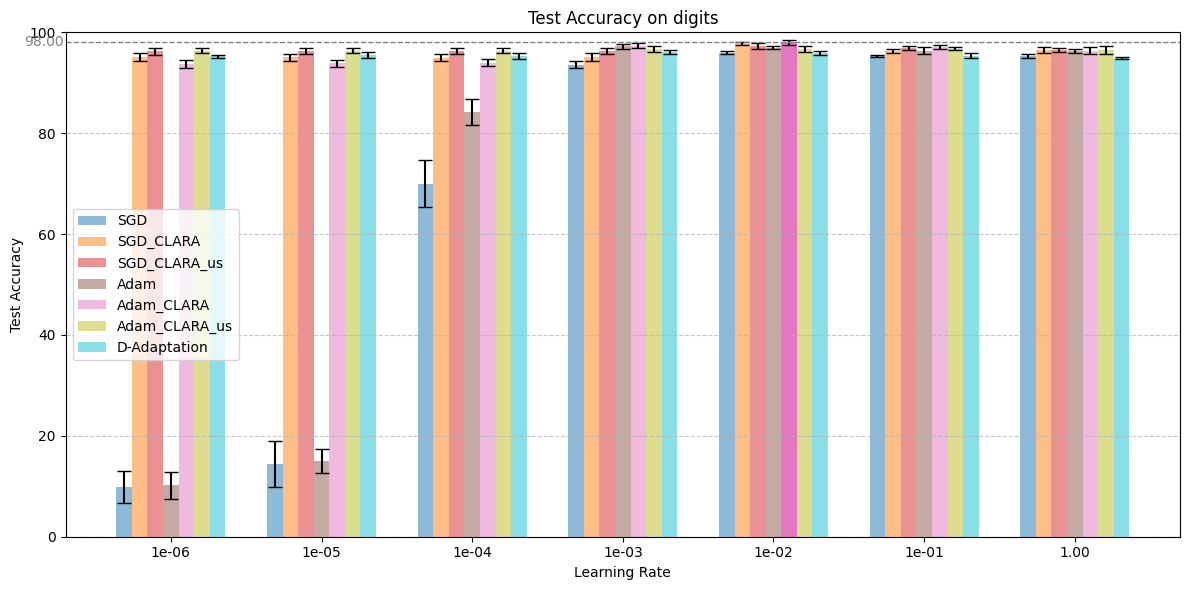

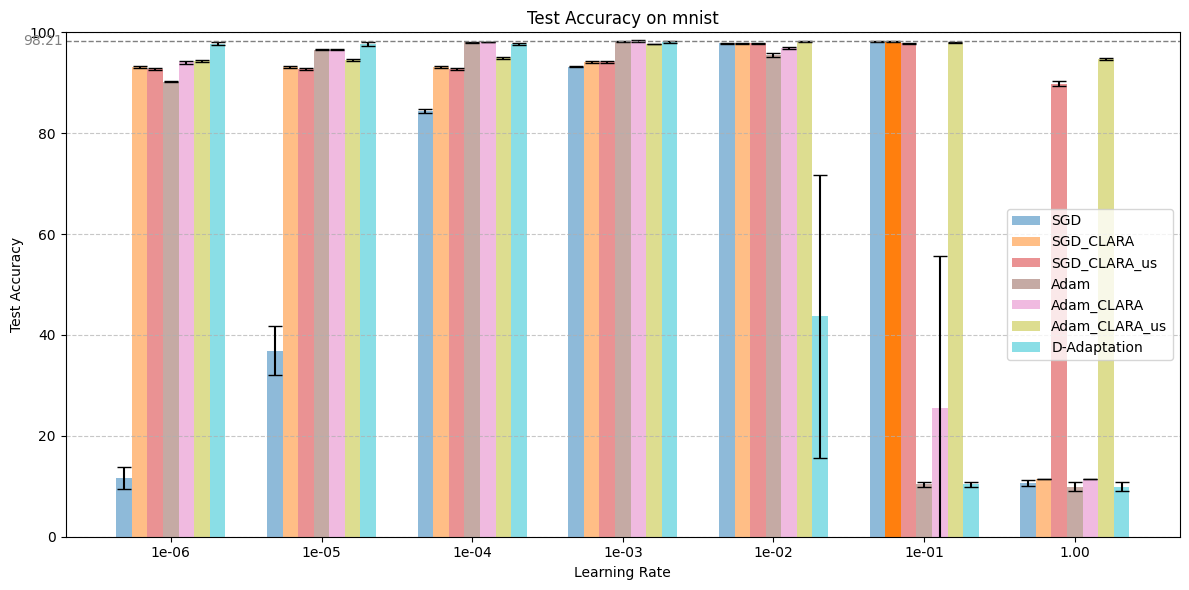

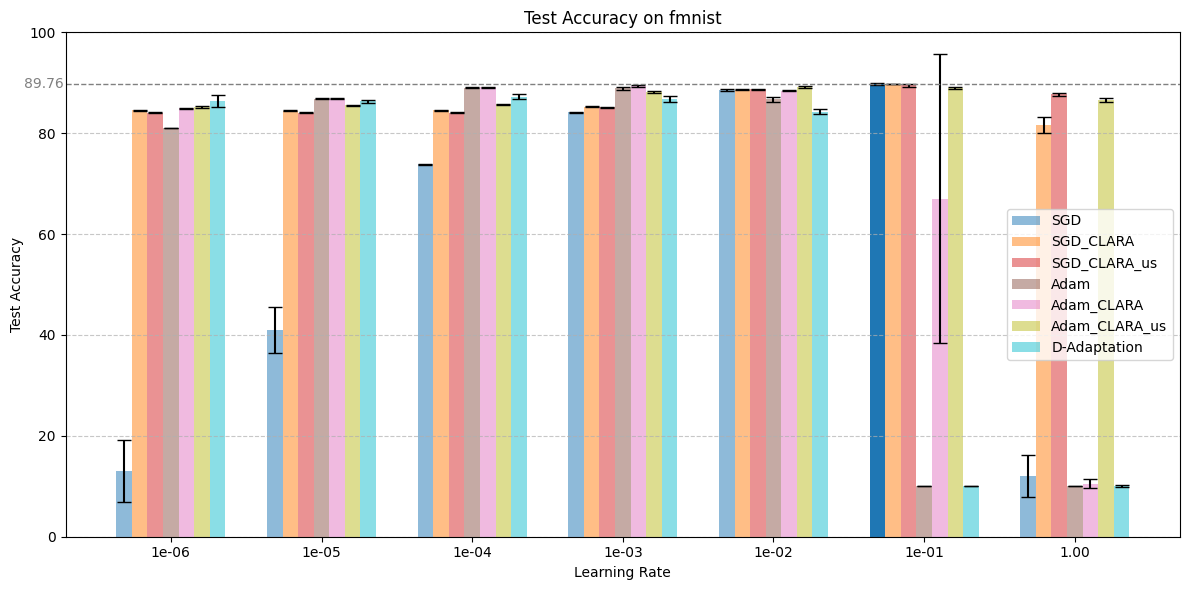

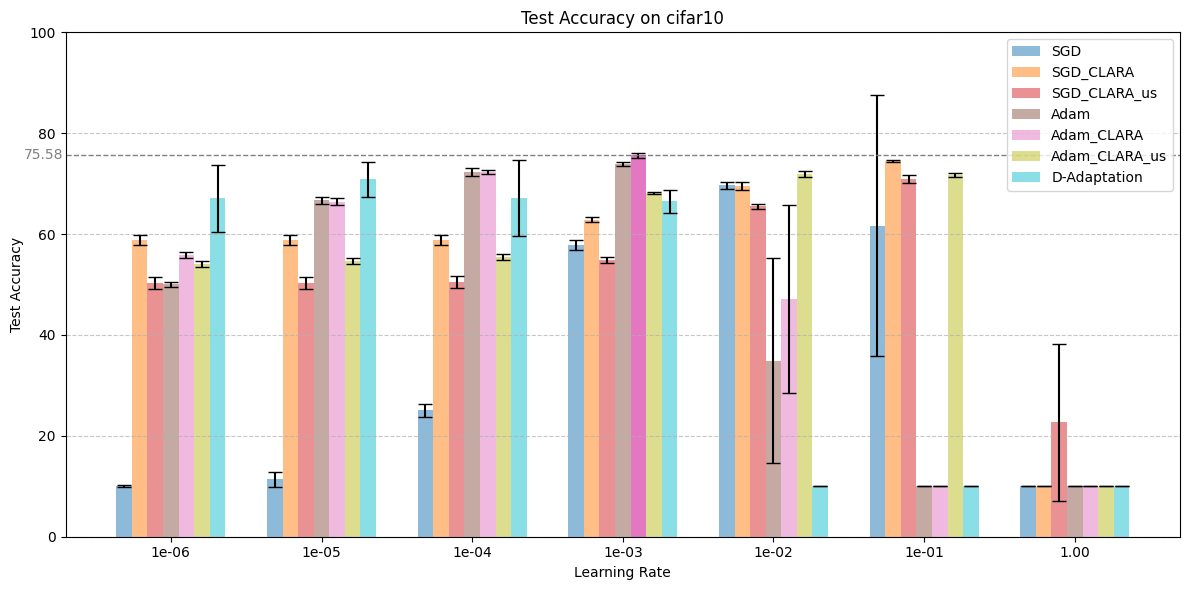

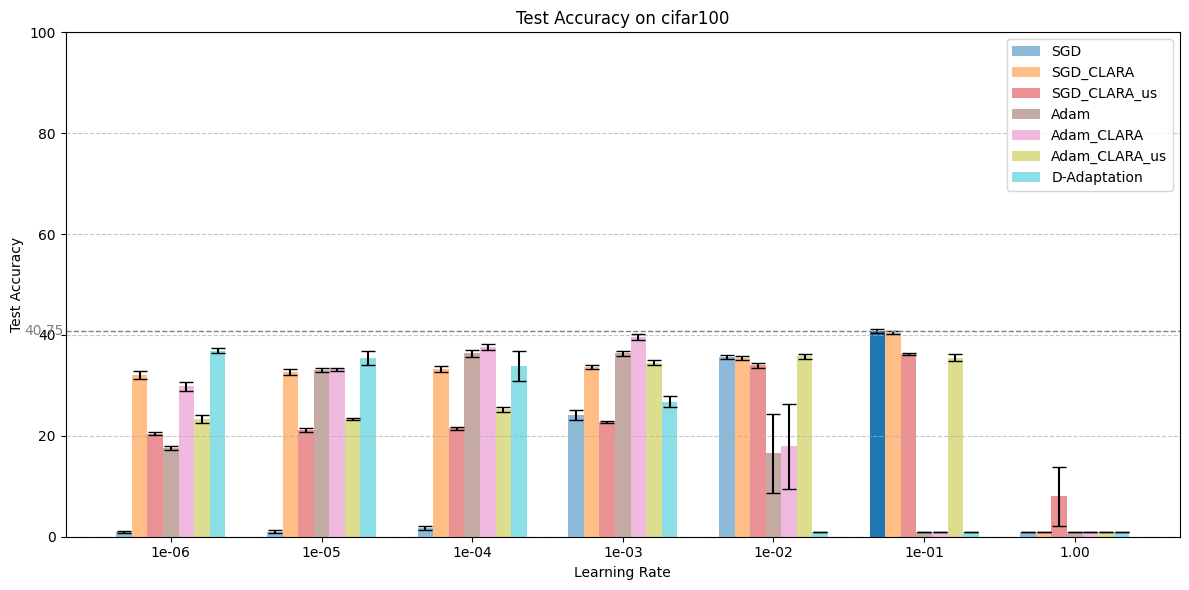

In [5]:
plot_algorithm_performance(
    summary_stats=summary,  # from your earlier function
    algorithms=["SGD", "SGD_CLARA", "SGD_CLARA_us", "Adam", "Adam_CLARA", "Adam_CLARA_us", "D-Adaptation"],
    datasets=["breast_cancer", "iris", "wine", "digits", "mnist", "fmnist", "cifar10", "cifar100"],
    lr_values=["1e-06", "1e-05", "1e-04", "1e-03", "1e-02", "1e-01", "1.00"],
    metric_name="Test Accuracy"
)

In [6]:
def plot_algorithm_performance_lines(summary_stats, algorithms, datasets, lr_values, metric_name="Test Accuracy"):
    """
    Plot line charts (instead of bar plots) with error bars for each algorithm at different learning rates,
    one plot per dataset. Each algorithm is represented by a different color and marker.
    """
    def get_algorithm_colors(algorithms):
        num_colors = len(algorithms)
        colormap = plt.get_cmap('tab10', num_colors)
        return {algorithm: colormap(i) for i, algorithm in enumerate(algorithms)}

    def get_markers():
        return ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '+']

    color_map = get_algorithm_colors(algorithms)
    marker_list = get_markers()

    for dataset in datasets:
        plt.figure(figsize=(10, 6))

        # Keeping track of the best test performance across algorithms and learning rate values
        global_best = {"val": -np.inf, "lr": None, "algo": None}

        for i, algorithm in enumerate(algorithms):
            means = []
            stds = []

            for lr in lr_values:
                val = summary_stats.get(lr, {}).get(algorithm, {}).get(dataset)
                if val:
                    mean, std = val
                else:
                    mean, std = np.nan, np.nan
                means.append(mean)
                stds.append(std)

            # Convert learning rates to float for plotting
            lr_floats = [float(lr) for lr in lr_values]
            plt.errorbar(
                lr_floats,
                means,
                yerr=stds,
                label=algorithm,
                marker=marker_list[i % len(marker_list)],
                color=color_map[algorithm],
                capsize=4,
                linestyle='-'
            )

            # Track global best point
            max_val = np.nanmax(means)
            if max_val > global_best["val"]:
                best_idx = np.nanargmax(means)
                global_best = {
                    "val": max_val,
                    "lr": float(lr_values[best_idx]),
                    "algo": algorithm
                }

        # Highlight best overall performance
        plt.plot(
            global_best["lr"], global_best["val"],
            marker='*', color='black', markersize=14,
            label="Best overall", zorder=5
        )
        plt.text(
            global_best["lr"], global_best["val"] + 1.5,
            f"{global_best['val']:.2f}",
            ha='center', va='bottom',
            fontsize=9, color='black', fontweight='bold'
        )

        plt.xscale("log")
        plt.xlabel("Learning Rate")
        plt.ylabel(metric_name)
        plt.title(f"{metric_name} on {dataset}")
        plt.ylim(0, 100)
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

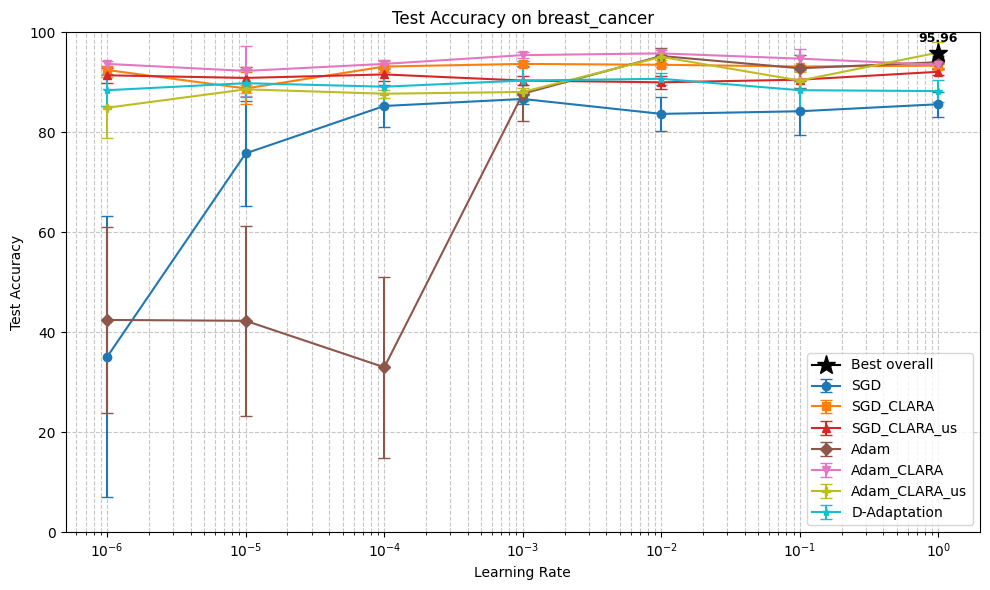

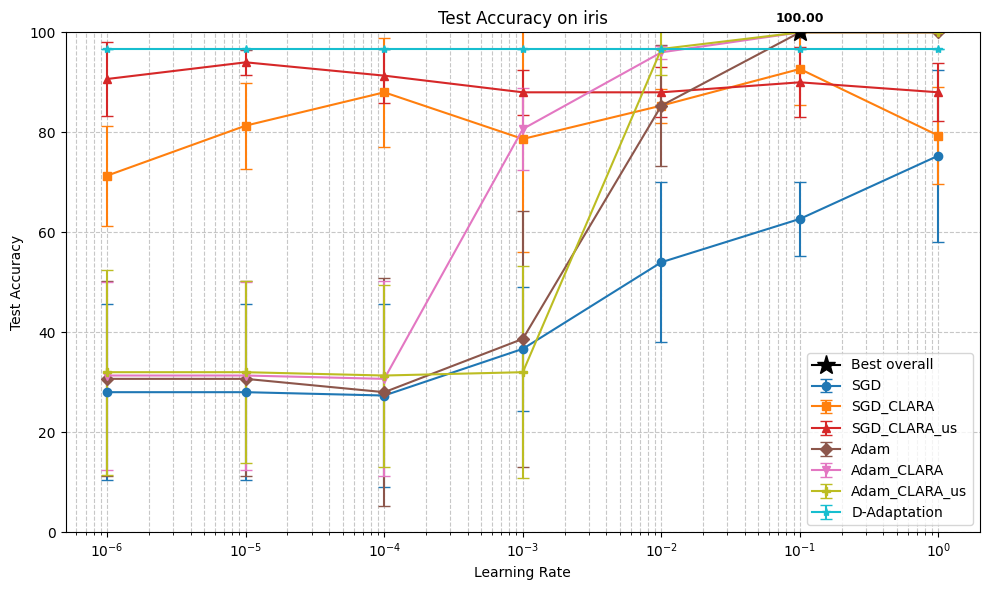

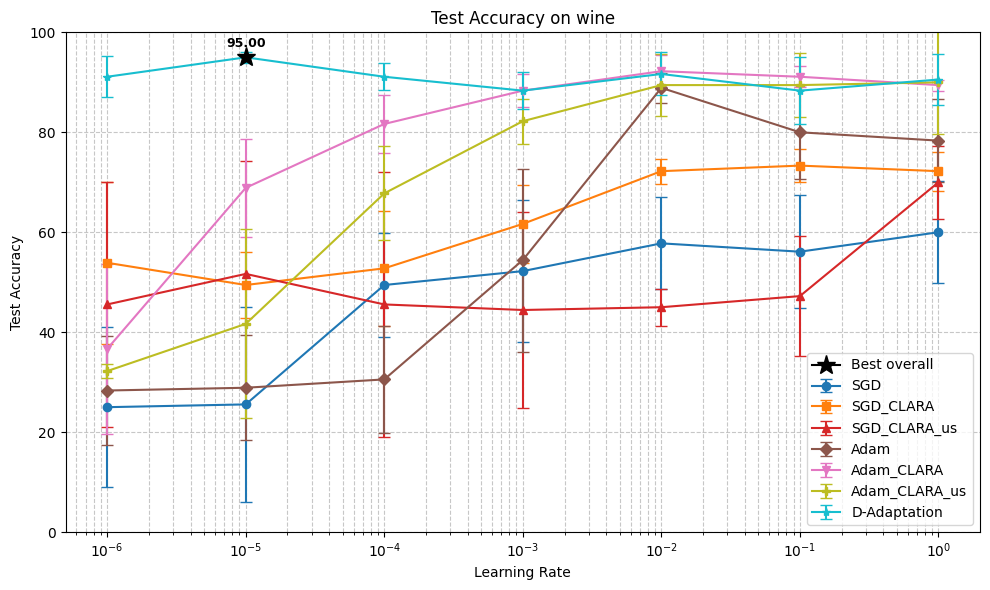

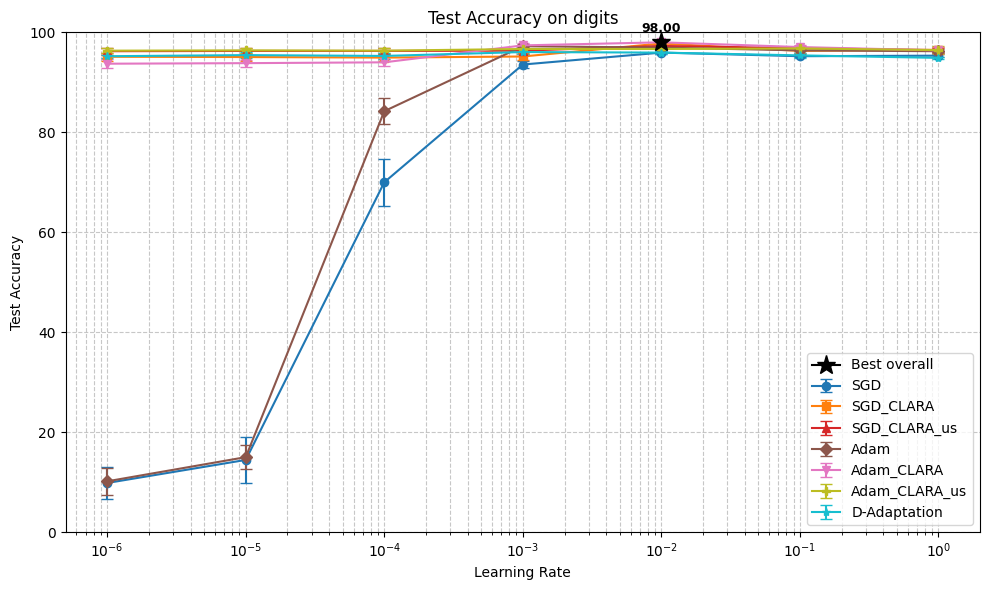

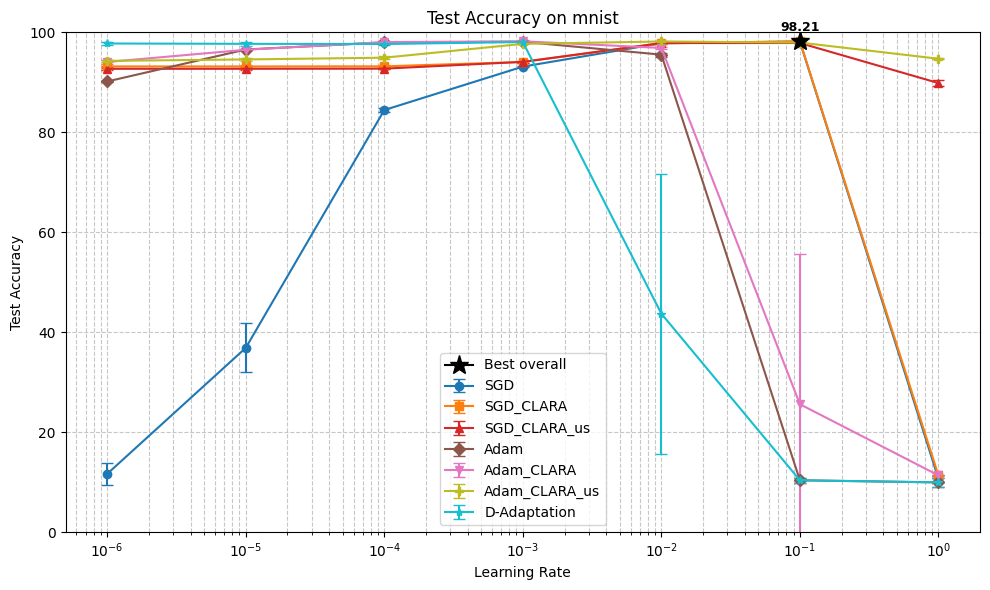

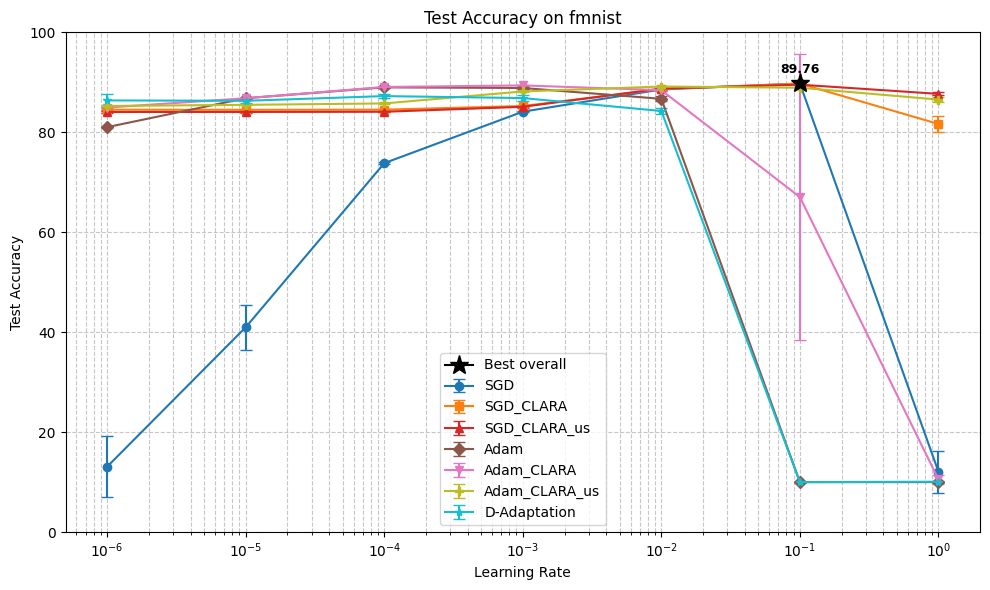

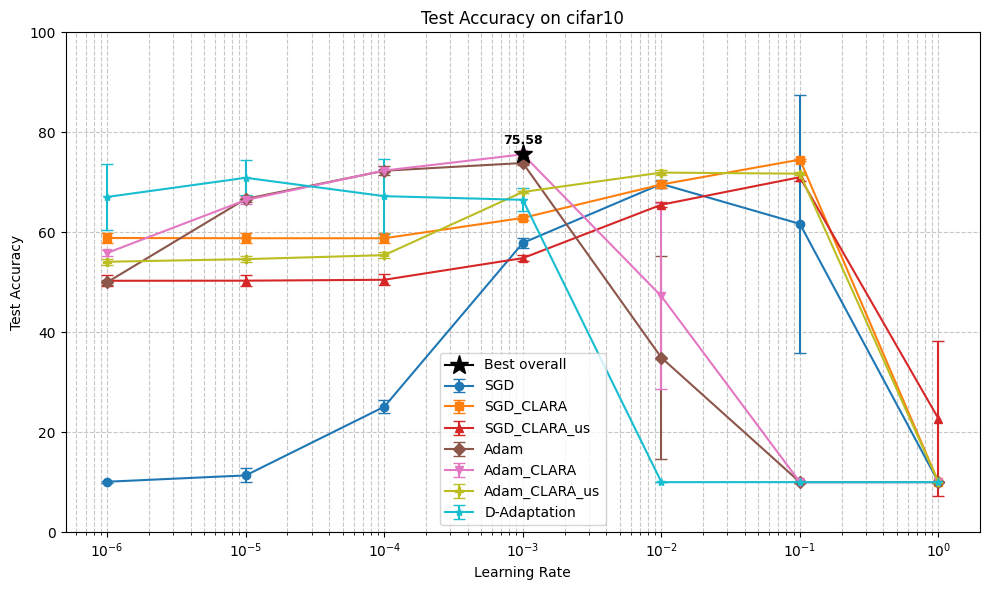

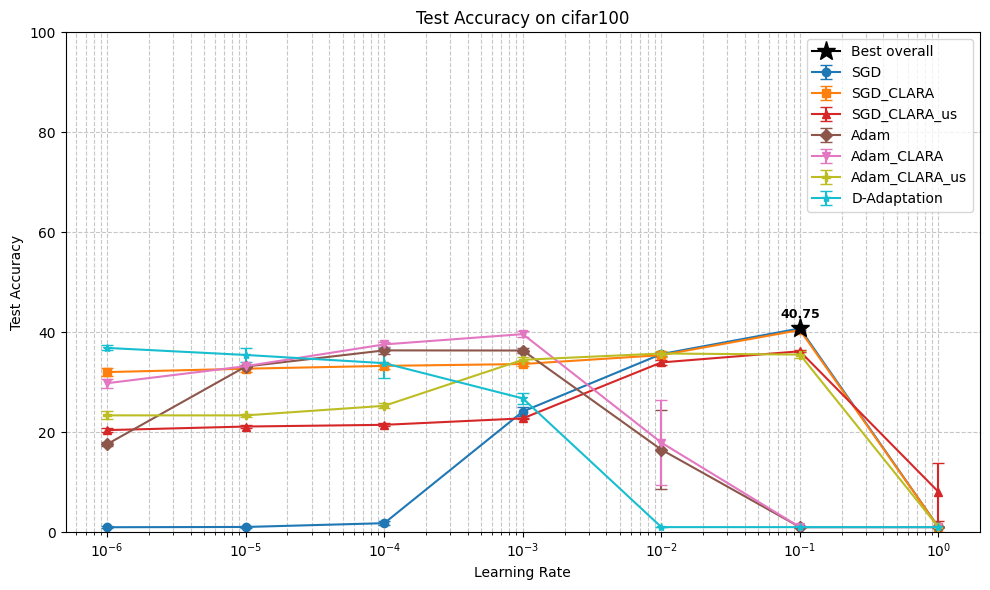

In [7]:
plot_algorithm_performance_lines(
    summary_stats=summary,
    algorithms=["SGD", "SGD_CLARA", "SGD_CLARA_us", "Adam", "Adam_CLARA", "Adam_CLARA_us", "D-Adaptation"],
    # algorithms=["SGD_CLARA", "SGD_CLARA_us", "Adam_CLARA", "Adam_CLARA_us"],
    datasets=["breast_cancer", "iris", "wine", "digits", "mnist", "fmnist", "cifar10", "cifar100"],
    lr_values=["1e-06", "1e-05", "1e-04", "1e-03", "1e-02", "1e-01", "1.00"],
    metric_name="Test Accuracy"
)

In [8]:
def plot_avg_performance_vs_damping(base_dir, algorithm, datasets, lr_values, metric="test_accuracy"):
    """
    For a given algorithm, plot average test performance across all datasets (with std deviation as error bars)
    as a function of damping value. Each line corresponds to a different learning rate.
    """
    # Pattern: date_time_epoch_seed_damping
    # folder_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2})_(\d+)_([\d]+)_([0-9eE\.-]+)")
    folder_pattern = re.compile(r"(\d+)_([\d]+)_([0-9eE\.-]+)_EpochSeedDamping")

    # results[damping][lr] = list of metric values (avg over datasets and seeds)
    results = defaultdict(lambda: defaultdict(list))

    for entry in os.listdir(base_dir):
        match = folder_pattern.match(entry)
        if not match:
            continue
        _, _, damping = match.groups()
        damping = float(damping)
        # print("Damping: ", damping)
        run_dir = os.path.join(base_dir, entry)

        for dataset in datasets:
            dataset_path = os.path.join(run_dir, dataset)
            if not os.path.isdir(dataset_path):
                continue

            for lr in lr_values:
                lr_path = os.path.join(dataset_path, f"lr{lr}")
                result_file = os.path.join(lr_path, f"{algorithm}.pkl")
                if os.path.isfile(result_file):
                    with open(result_file, "rb") as f:
                        data = pickle.load(f)
                        value = data.get(metric)
                        if value is not None:
                            results[damping][lr].append(value)

    # Sort damping values
    damping_values = sorted(results.keys())
    plt.figure(figsize=(10, 6))

    for lr in lr_values:
        means = []
        stds = []
        for damping in damping_values:
            vals = results[damping].get(lr, [])
            if vals:
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        plt.errorbar(damping_values, means, yerr=stds, marker='o', label=f"lr={lr}")

    plt.xscale("log")
    plt.xlabel("Damping")
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.title(f"{metric.replace('_', ' ').capitalize()} vs Damping for {algorithm}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

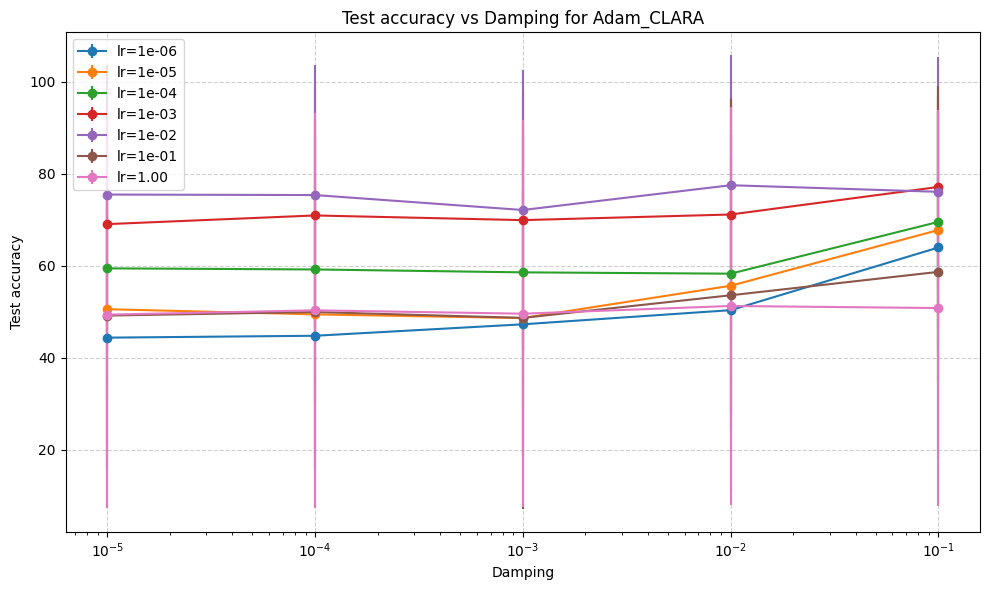

In [9]:
plot_avg_performance_vs_damping(
    base_dir="TM_Experiments/selected_results/damping_experiments/",
    algorithm="Adam_CLARA",
    datasets=["breast_cancer", "iris", "wine", "digits", "mnist", "fmnist", "cifar10", "cifar100"],
    lr_values=["1e-06", "1e-05", "1e-04", "1e-03", "1e-02", "1e-01", "1.00"],
    metric="test_accuracy"
)

# algorithms=["SGD", "SGD_CLARA", "SGD_CLARA_us", "Adam", "Adam_CLARA", "Adam_CLARA_us", "D-Adaptation"]

In [10]:
def plot_performance_vs_damping_per_dataset(base_dir, algorithm, datasets, lr_values, metric="test_accuracy"):
    """
    For a given algorithm, plot test performance as a function of damping (with error bars) for each dataset
    and each learning rate. Creates one plot per dataset. Also prints the best damping per learning rate.
    """
    # folder_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2})_(\d+)_([\d]+)_([0-9eE\.-]+)")
    folder_pattern = re.compile(r"(\d+)_([\d]+)_([0-9eE\.-]+)_EpochSeedDamping")

    for dataset in datasets:
        results = defaultdict(lambda: defaultdict(list))  # results[damping][lr] = list of metric values

        for entry in os.listdir(base_dir):
            match = folder_pattern.match(entry)
            if not match:
                continue
            _, _, damping = match.groups()
            damping = float(damping)
            run_dir = os.path.join(base_dir, entry)

            dataset_path = os.path.join(run_dir, dataset)
            if not os.path.isdir(dataset_path):
                continue

            for lr in lr_values:
                lr_path = os.path.join(dataset_path, f"lr{lr}")
                result_file = os.path.join(lr_path, f"{algorithm}.pkl")
                if os.path.isfile(result_file):
                    with open(result_file, "rb") as f:
                        data = pickle.load(f)
                        value = data.get(metric)
                        if value is not None:
                            results[damping][lr].append(value)

        # Create the plot for this dataset
        plt.figure(figsize=(10, 6))
        damping_values = sorted(results.keys())

        print(f"\nBest damping values for {algorithm} on {dataset}:")
        for lr in lr_values:
            means = []
            stds = []
            for damping in damping_values:
                vals = results[damping].get(lr, [])
                if vals:
                    means.append(np.mean(vals))
                    stds.append(np.std(vals))
                else:
                    means.append(np.nan)
                    stds.append(np.nan)

            # Print best damping value for this lr (ignoring NaNs)
            valid_data = [(d, m) for d, m in zip(damping_values, means) if not np.isnan(m)]
            if valid_data:
                best_damping, best_value = max(valid_data, key=lambda x: x[1])
                print(f"  lr={lr}: best damping = {best_damping:.2e} (mean {best_value:.4f})")

                # Copy model in destination folder
                for s in range(0, 5):
                    source_path = f"TM_Experiments/selected_results/damping_experiments/100_{s}_{best_damping:.0e}_EpochSeedDamping/{dataset}/lr{lr}/{algorithm}.pkl"
                    dest_path = f"TM_Experiments/selected_results/100_{s}_EpochSeed/{dataset}/lr{lr}/"
                    shutil.copy(source_path, dest_path)
                    # pass

            plt.errorbar(
                damping_values,
                means,
                yerr=stds,
                marker='o',
                label=f"lr={lr}",
                capsize=5
            )

        plt.xscale("log")
        plt.xlabel("Damping (log scale)")
        plt.ylabel(metric.replace("_", " ").capitalize())
        plt.title(f"{metric.replace('_', ' ').capitalize()} vs Damping for {algorithm} on {dataset}")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


Best damping values for Adam_CLARA on breast_cancer:
  lr=1e-06: best damping = 1.00e-01 (mean 93.6842)
  lr=1e-05: best damping = 1.00e-01 (mean 92.2807)
  lr=1e-04: best damping = 1.00e-01 (mean 93.6842)
  lr=1e-03: best damping = 1.00e-01 (mean 95.4386)
  lr=1e-02: best damping = 1.00e-04 (mean 95.7895)
  lr=1e-01: best damping = 1.00e-01 (mean 94.7368)
  lr=1.00: best damping = 1.00e-01 (mean 93.5088)


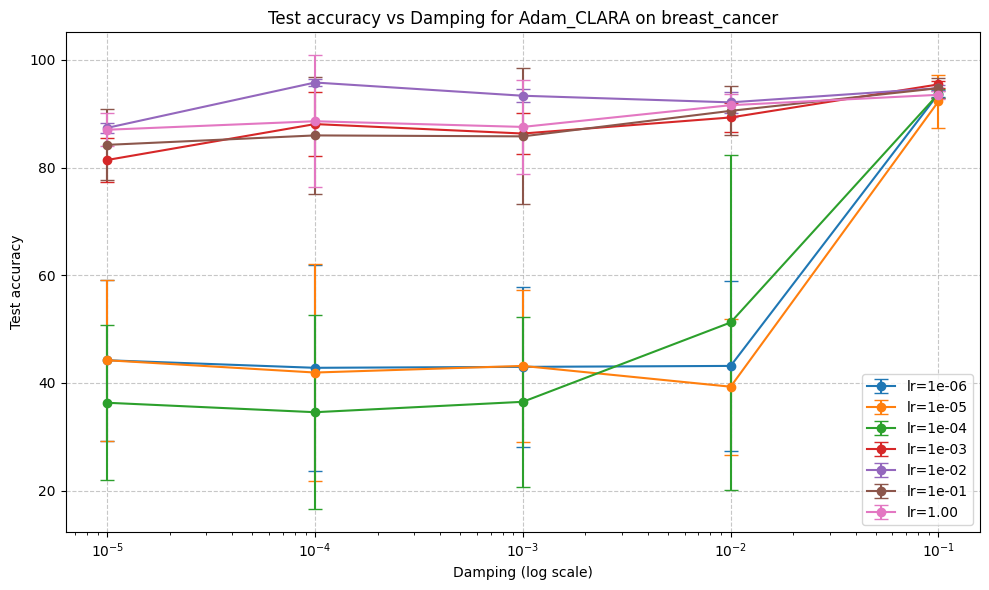


Best damping values for Adam_CLARA on iris:
  lr=1e-06: best damping = 1.00e-03 (mean 31.3333)
  lr=1e-05: best damping = 1.00e-03 (mean 31.3333)
  lr=1e-04: best damping = 1.00e-04 (mean 30.6667)
  lr=1e-03: best damping = 1.00e-01 (mean 80.6667)
  lr=1e-02: best damping = 1.00e-01 (mean 96.0000)
  lr=1e-01: best damping = 1.00e-04 (mean 100.0000)
  lr=1.00: best damping = 1.00e-03 (mean 100.0000)


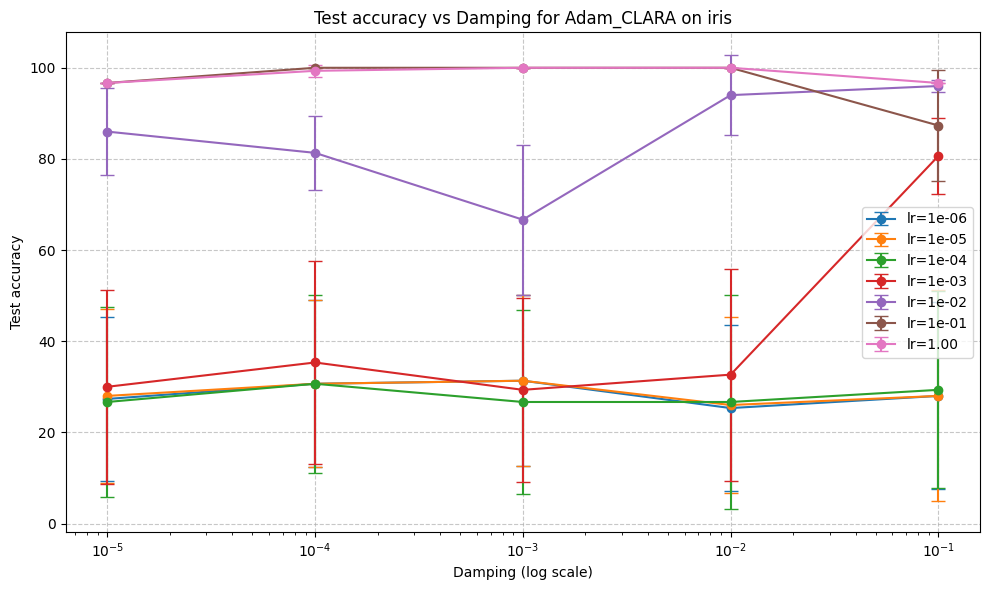


Best damping values for Adam_CLARA on wine:
  lr=1e-06: best damping = 1.00e-01 (mean 36.6667)
  lr=1e-05: best damping = 1.00e-01 (mean 68.8889)
  lr=1e-04: best damping = 1.00e-01 (mean 81.6667)
  lr=1e-03: best damping = 1.00e-01 (mean 88.3333)
  lr=1e-02: best damping = 1.00e-05 (mean 92.2222)
  lr=1e-01: best damping = 1.00e-02 (mean 91.1111)
  lr=1.00: best damping = 1.00e-02 (mean 89.4444)


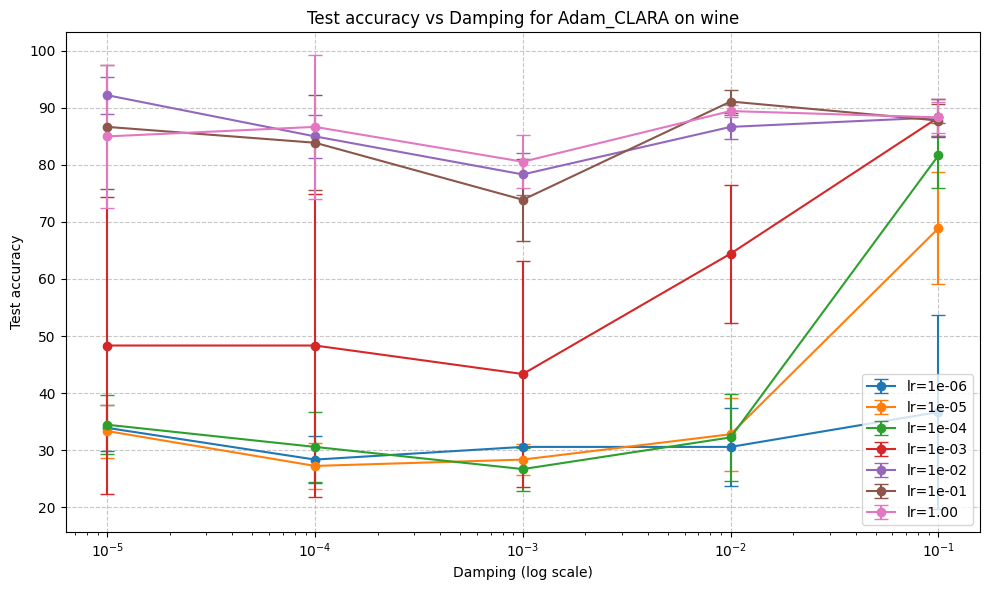


Best damping values for Adam_CLARA on digits:
  lr=1e-06: best damping = 1.00e-01 (mean 93.7222)
  lr=1e-05: best damping = 1.00e-01 (mean 93.8333)
  lr=1e-04: best damping = 1.00e-01 (mean 94.0000)
  lr=1e-03: best damping = 1.00e-03 (mean 97.3889)
  lr=1e-02: best damping = 1.00e-03 (mean 98.0000)
  lr=1e-01: best damping = 1.00e-03 (mean 97.0556)
  lr=1.00: best damping = 1.00e-02 (mean 96.3889)


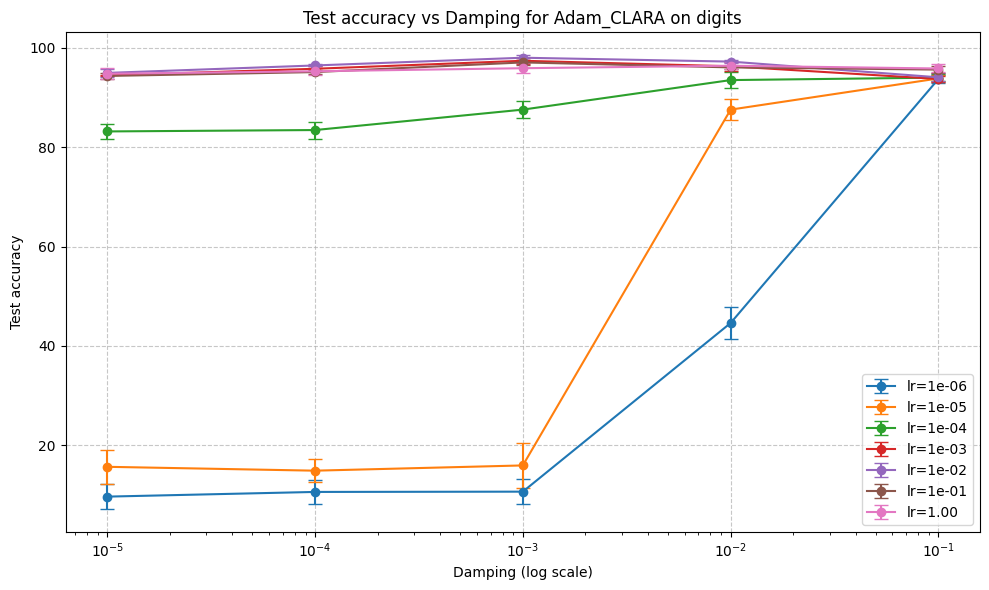


Best damping values for Adam_CLARA on mnist:
  lr=1e-06: best damping = 1.00e-03 (mean 94.0640)
  lr=1e-05: best damping = 1.00e-05 (mean 96.5160)
  lr=1e-04: best damping = 1.00e-04 (mean 98.0440)
  lr=1e-03: best damping = 1.00e-04 (mean 98.2080)
  lr=1e-02: best damping = 1.00e-03 (mean 96.8780)
  lr=1e-01: best damping = 1.00e-01 (mean 25.5920)
  lr=1.00: best damping = 1.00e-03 (mean 11.3520)


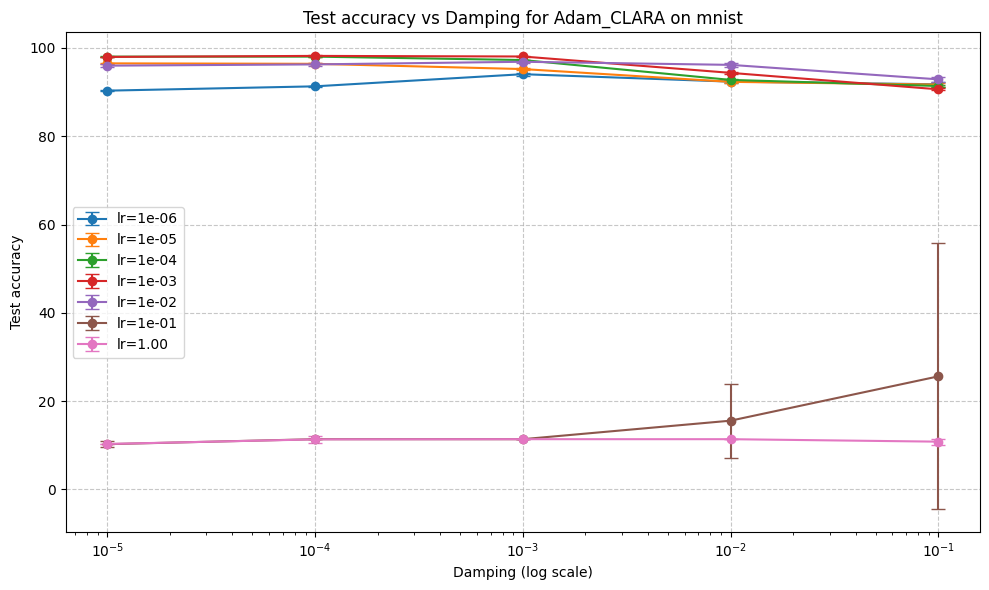


Best damping values for Adam_CLARA on fmnist:
  lr=1e-06: best damping = 1.00e-03 (mean 84.9500)
  lr=1e-05: best damping = 1.00e-05 (mean 86.8100)
  lr=1e-04: best damping = 1.00e-04 (mean 89.0680)
  lr=1e-03: best damping = 1.00e-03 (mean 89.3800)
  lr=1e-02: best damping = 1.00e-02 (mean 88.4240)
  lr=1e-01: best damping = 1.00e-01 (mean 67.0340)
  lr=1.00: best damping = 1.00e-01 (mean 10.5480)


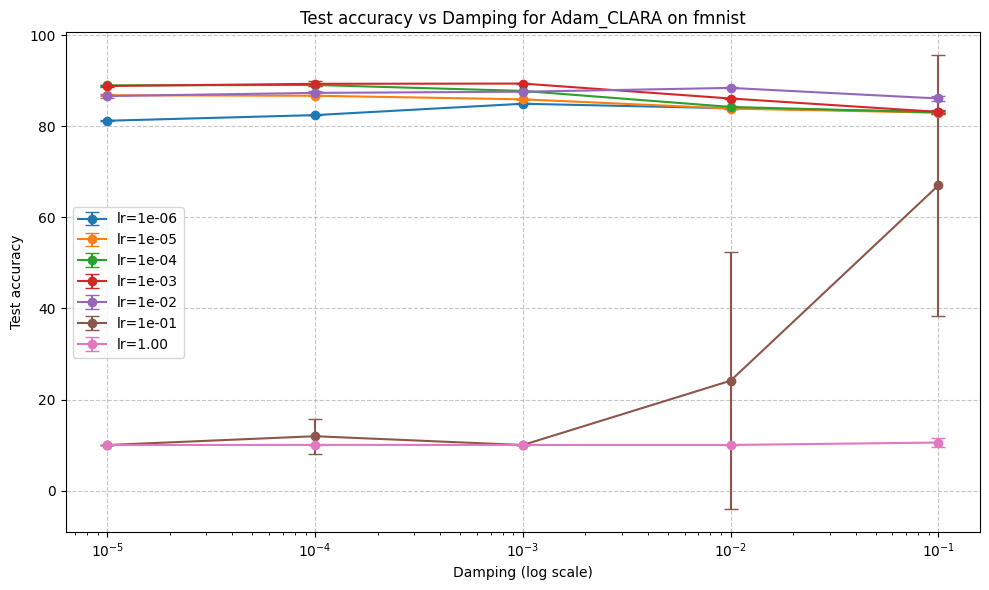


Best damping values for Adam_CLARA on cifar10:
  lr=1e-06: best damping = 1.00e-03 (mean 55.8640)
  lr=1e-05: best damping = 1.00e-05 (mean 66.4460)
  lr=1e-04: best damping = 1.00e-05 (mean 72.3480)
  lr=1e-03: best damping = 1.00e-03 (mean 75.5840)
  lr=1e-02: best damping = 1.00e-02 (mean 47.2060)
  lr=1e-01: best damping = 1.00e-05 (mean 10.0000)
  lr=1.00: best damping = 1.00e-05 (mean 10.0020)


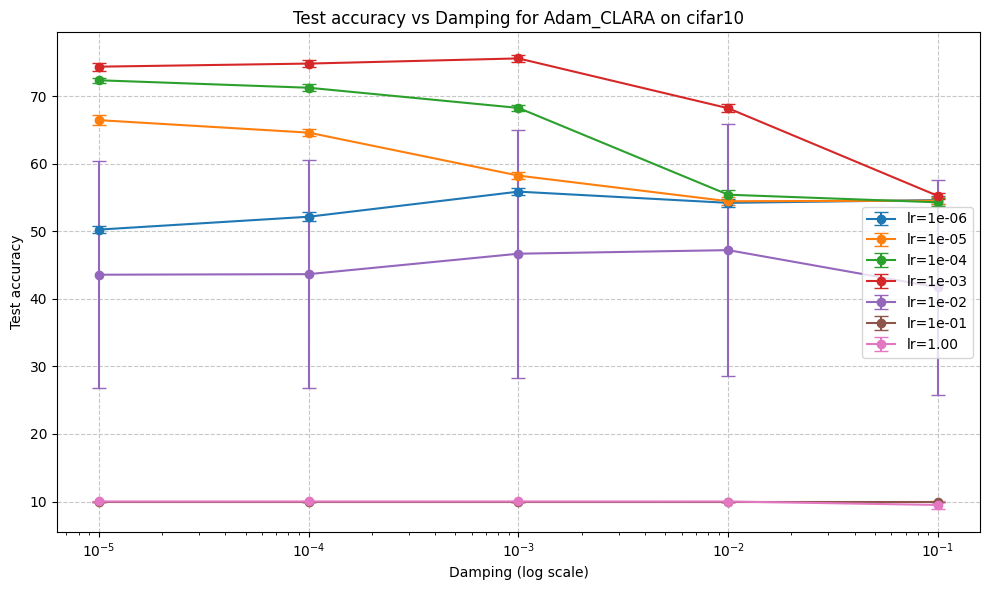


Best damping values for Adam_CLARA on cifar100:
  lr=1e-06: best damping = 1.00e-01 (mean 29.8020)
  lr=1e-05: best damping = 1.00e-05 (mean 33.2020)
  lr=1e-04: best damping = 1.00e-03 (mean 37.5580)
  lr=1e-03: best damping = 1.00e-03 (mean 39.6140)
  lr=1e-02: best damping = 1.00e-02 (mean 17.9060)
  lr=1e-01: best damping = 1.00e-05 (mean 1.0000)
  lr=1.00: best damping = 1.00e-05 (mean 1.0000)


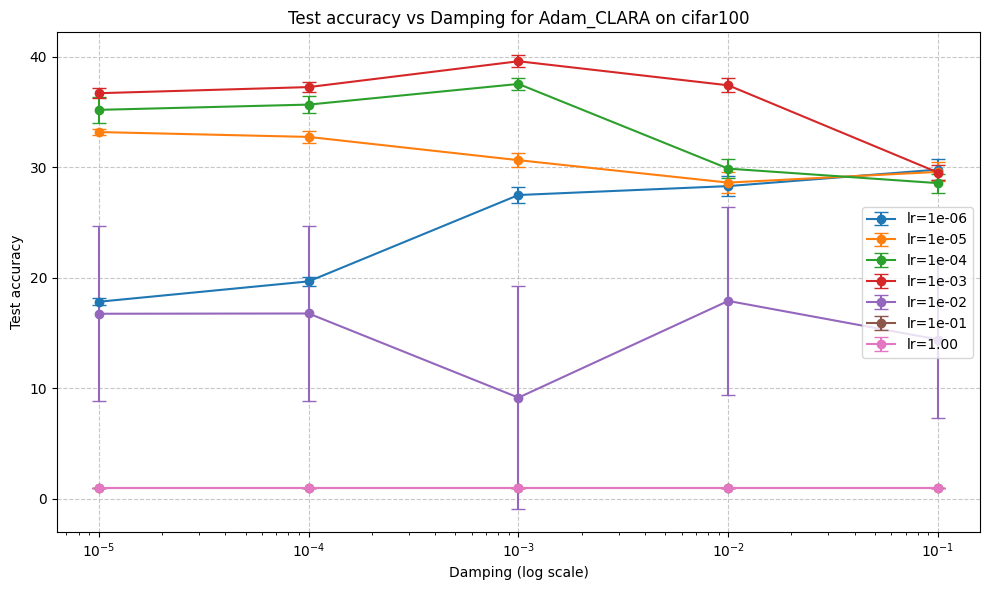

In [12]:
plot_performance_vs_damping_per_dataset(
    base_dir="TM_Experiments/selected_results/damping_experiments/",
    algorithm="Adam_CLARA",
    datasets=["breast_cancer", "iris", "wine", "digits", "mnist", "fmnist", "cifar10", "cifar100"],
    lr_values=["1e-06", "1e-05", "1e-04", "1e-03", "1e-02", "1e-01", "1.00"],
    metric="test_accuracy"
)